In [ ]:
!pip install pyLDAvis


In [ ]:
!pip install sentence_transformers


In [ ]:
!pip install bertopic

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import re
import torch
import torch.nn as nn
import gensim.corpora as corpora
import gensim
import string
import pyLDAvis
import pyLDAvis.gensim_models

from matplotlib import pyplot as plt
from pprint import pprint
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel, pipeline, get_linear_schedule_with_warmup
)

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from bertopic import BERTopic

torch.manual_seed(42)
torch.backends.cuda.deterministic = True

%matplotlib inline

In [ ]:
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
stop_words = stopwords.words('russian')

def preprocess(text, join_back=True):
    text =  re.sub(r'\n', '', text)
    text = re.sub(r'[^\w\s]','', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = text.lower()

    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop_words:
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result




In [ ]:
import torch
# torch.cuda.is_available()
     
from sentence_transformers import SentenceTransformer

sent_tr = SentenceTransformer('distiluse-base-multilingual-cased-v1',device="cuda")


In [20]:
df_not_labeled = pd.read_csv("/content/drive/MyDrive/dataset_labeled/text_table_processed.csv")

# **Try to build some statistics with Date and Time features. Number of posts in different months, day of weeks, time of day and etc.**

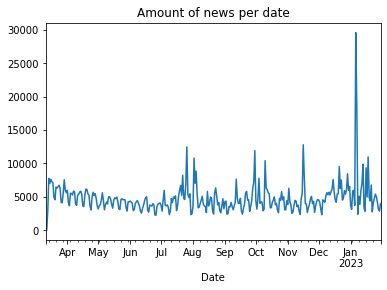

In [8]:
df_not_labeled["Date"] = pd.to_datetime(df_not_labeled["Date"])
df_not_labeled.groupby(df_not_labeled["Date"])["Text"].count().plot()
plt.title("Amount of news per date")
plt.show()

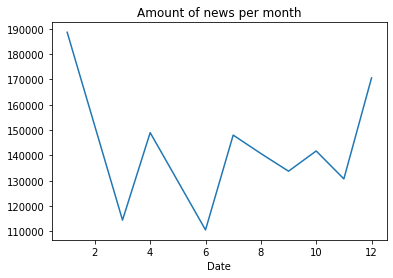

In [5]:
df_not_labeled["Date"] = pd.to_datetime(df_not_labeled["Date"])
df_not_labeled.groupby(df_not_labeled["Date"].dt.month)["Text"].count().plot()
plt.title("Amount of news per month")
plt.show()

**The least amount of news was added in March and July**

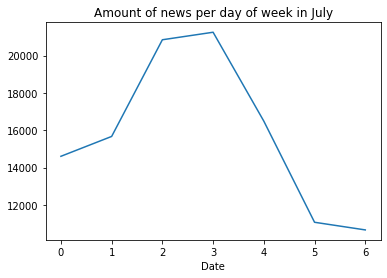

In [60]:
df_day_of_week = df_not_labeled[df_not_labeled["Date"].dt.month==6]
df_day_of_week.groupby(df_day_of_week["Date"].dt.dayofweek)["Text"].count().plot()
plt.title("Amount of news per day of week in July")
plt.show()

**In July the most productive day was Thursday**

In [56]:
df_day = df_day_of_week[df_day_of_week["Date"].dt.dayofweek == 3]


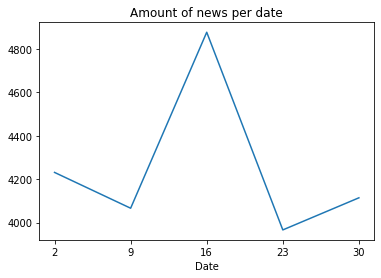

In [61]:
df_day.groupby(df_day["Date"].dt.day)["Text"].count().plot(xticks=df_day["Date"].dt.day.unique())
plt.title("Amount of news per date")
plt.show()

**The most productive day was 16 July**

<AxesSubplot:xlabel='Time'>

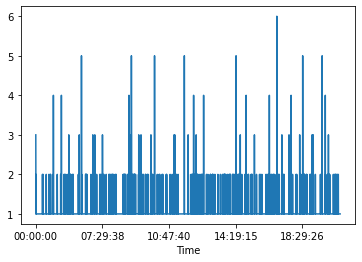

In [57]:
df_time = df_day[df_day["Date"].dt.day==16]
df_time.groupby(df_time["Time"])["Text"].count().plot()


**On that day there was approximately the same amount of news per hour**

Also we can look over all statistics per day

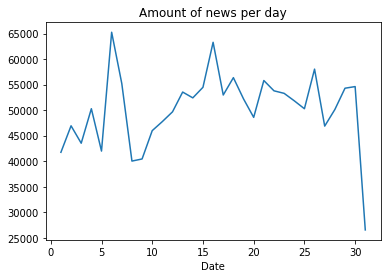

In [62]:
df_not_labeled["Date"] = pd.to_datetime(df_not_labeled["Date"])
df_not_labeled.groupby(df_not_labeled["Date"].dt.day)["Text"].count().plot()
plt.title("Amount of news per day")
plt.show()

**The least news was added on the 31st. it's because not every month has 31 days**

# **Try to apply clustering; dimensionality reduction + clustering; topic modelling for finding interesting topics**

In [ ]:
# df_not_labeled["Text_processed"].isnull().sum()
df_not_labeled = df_not_labeled[df_not_labeled['Text_processed'].notna()]

df_not_labeled = df_not_labeled[df_not_labeled["lang"] == 'ru']
df_not_labeled = df_not_labeled.iloc[:df_not_labeled.shape[0]//2]

df_not_labeled['Text_processed_clean'] = df_not_labeled['Text_processed'].apply(preprocess)
df_not_labeled.to_csv("Not_labeled_Cleaned_ds.csv")


In [64]:
df_not_labeled = pd.read_csv("/content/drive/MyDrive/dataset_labeled/Not_labeled_Cleaned_ds.csv")

In [ ]:

embs = sent_tr.encode(df_not_labeled["Text_processed_clean"].to_list())
np.save('embeddings.npy', np.array(embs))


In [65]:
# downloading embs, unlabeled data
embs = np.load('/content/drive/MyDrive/dataset_labeled/embeddings.npy')


In [ ]:
# embs = np.load('/content/drive/MyDrive/dataset_labeled/news_embeddings.npy')

# **TSNE**

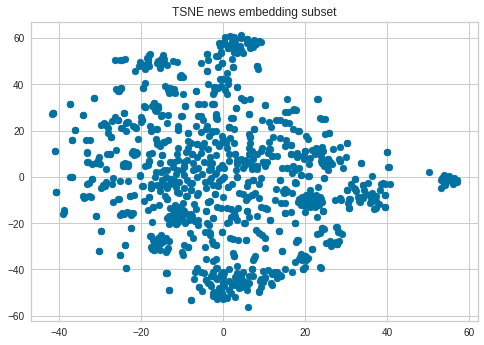

In [ ]:
tsne_news_embeddings_subset = TSNE(random_state=42).fit_transform(embs[:1000])

plt.title("TSNE news embedding subset")
plt.scatter(tsne_news_embeddings_subset[:,0], tsne_news_embeddings_subset[:,1])
plt.show()

Find the optimal value for K

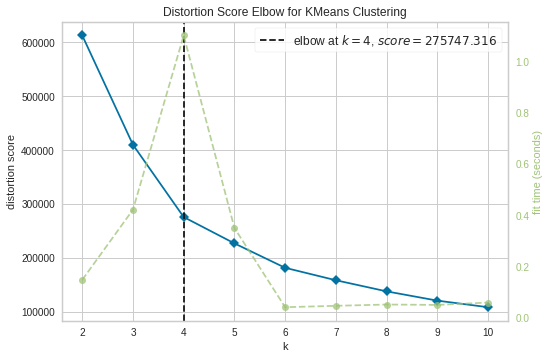

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)

elb_visualizer = KElbowVisualizer(model, k=(2,11))
elb_visualizer.fit(tsne_news_embeddings_subset)    
elb_visualizer.show()  

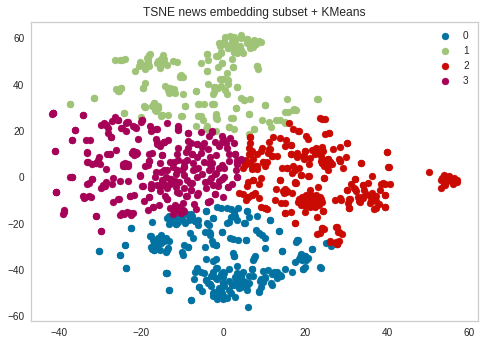

In [ ]:
kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=4, 
    random_state=42, 
    init="k-means++"
).fit_predict(tsne_news_embeddings_subset)

plt.title("TSNE news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
df_not_labeled.iloc[:1000][kmeans_clusts_news_embeddings_subset == 2].Text_processed.to_list()[25:40]

['Куряне присоединились к эстафете  Акцию в поддержку российских военнослужащих, которые участвуют в спецоперации на Украине, запустили в Ростовской области, а к нам она пришла от соседей из Белгорода. Главный символ эстафеты латинская буква Z. Обязательно поделитесь этим видео! . эстафета Россия_Мы',
 'Куряне присоединились к эстафете  Акцию в поддержку российских военнослужащих, которые участвуют в спецоперации на Украине, запустили в Ростовской области, а к нам она пришла от соседей из Белгорода. Главный символ эстафеты латинская буква Z. Обязательно поделитесь этим видео! . эстафета Россия_Мы',
 'Запечатленные на кадрах люди направляются на Украину после сбора в аэропорту.',
 'Куряне присоединились к эстафете  Акцию в поддержку российских военнослужащих, которые участвуют в спецоперации на Украине, запустили в Ростовской области, а к нам она пришла от соседей из Белгорода. Главный символ эстафеты латинская буква Z. Обязательно поделитесь этим видео! . эстафета Россия_Мы',
 'Оркестр

1. **we need to drop duplicates**
2. **on the elbow picture there is no inflection point, so we can't choose optimal number of clusters**

## drop duplicates

In [69]:
df_no_dupl = df_not_labeled.drop_duplicates("Text_processed_clean")

news_embeddings_no_dupl = embs[df_no_dupl.index.values]
df_no_dupl = df_no_dupl.reset_index(drop=True)

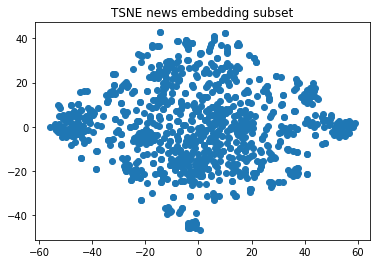

In [70]:
tsne_news_embeddings_subset_no_dupl = TSNE(random_state=42).fit_transform(news_embeddings_no_dupl[:1000])

plt.title("TSNE news embedding subset")
plt.scatter(tsne_news_embeddings_subset_no_dupl[:,0], tsne_news_embeddings_subset_no_dupl[:,1])
plt.show()

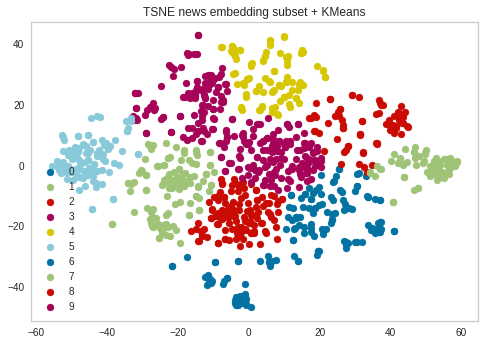

In [108]:
# bigger amount of clusters, n_clusters = 10

kmeans_clusts_news_embeddings_subset_no_dupl = KMeans(
    n_clusters=10, 
    random_state=42, 
    init="k-means++"
).fit_predict(tsne_news_embeddings_subset_no_dupl)

plt.title("TSNE news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset_no_dupl):
    plt.scatter(
        tsne_news_embeddings_subset_no_dupl[kmeans_clusts_news_embeddings_subset_no_dupl == clust, 0],
        tsne_news_embeddings_subset_no_dupl[kmeans_clusts_news_embeddings_subset_no_dupl == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.grid(False)
plt.show()

**Новини про підтримку війни з боку росіян**

In [119]:
df_no_dupl.iloc[:1000][kmeans_clusts_news_embeddings_subset_no_dupl == 9].Text_processed.to_list()[5:20]

['Будете мешать будем бить сильнее . Люди в России выходят на улицы против войны с Украиной. (зеркало: . На видео силовики вшестером задерживают прохожего в Петербурге, который снимал протесты на телефон. Запись Новой газеты . вшестером',
 'В Херсоне сегодня проходит проукраинский митинг. Колонна отправилась от ОГА к Вечному огню. Генштаб сообщает, что российская войска начали открывать предупредительный огонь. Этот момент попал на видео одного из участников митинга. Владимир Зеленский также обратился ко всем людям, вышедшим на митинги и в других городах: "Я благодарен каждому. Каждому, кто не сдается. Кто протестует. Кто демонстрирует оккупантам, что Украина наша земля. Херсон, Мелитополь, Бердянск и другие города. Украина победит! ", сказано в сообщении Владимира Зеленского. VESTI',
 'Полностью поддерживаю решение Президента РФ о проведении демилитаризации и денацификации Украины. Спасибо нашим воинам, которые мужественно выполняют свой долг. Мои родные и близкие сейчас находятся в г

**Новини про біженців та гуманітарку**

In [113]:
df_no_dupl.iloc[:1000][kmeans_clusts_news_embeddings_subset_no_dupl == 4].Text_processed.to_list()[:15]

['В Гомельскую область через белорусско-украинскую границу прибыли порядка 680 граждан Украины с 24 февраля.',
 'В Хабаровске прошел автопробег в поддержку спецоперации ВС РФ на Украине: Фото: ТРК "Звезда"',
 '[20/58] Кунгир кумирнинг йирик конлари кайси давлатларда жойлашган. Россия , Чехия , Полша. Германия , Чехия , Полша. Полша, Украина , Чехия',
 '[45/58] Европадаги темир рудасининг йирик конлари кайси давлатларда жойлашган. Германия, Франсия, Россия , Белорусы, Полша. Россия, Украина , Германия, Франсия , Италия. Германия, Россия , Украина , Шветсия , Франсия',
 '[29/58] Тошкумирнинг йирик конлари каерларда осилган ? Буду Британия , Германия , Полша. Германия, Россия, Украина. Россия , Украина , Чехия',
 'Из Киева сообщают: большинство стран западных демократий в ближайшие часы начнут переводить свои посольства в пограничные с Украиной страны. Все понимают, что будет дальше',
 'Известно, что гуманитарная помощь гражданам Украины будет направлена двумя рейсами 14 и 15 марта 2022 г

### **DBSCAN**

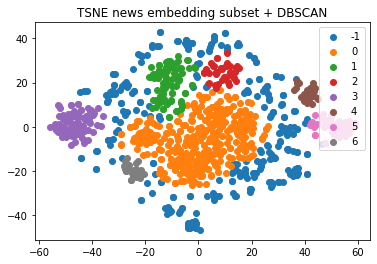

In [86]:

dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=6,
    min_samples=25
).fit_predict(tsne_news_embeddings_subset_no_dupl)

plt.title("TSNE news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset_no_dupl[dbscan_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset_no_dupl[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

**Наприклад, в кластері 6 містяться записи про загиблих**

In [103]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 6].Text.to_list()[:10]


['Губернатор Александр Бурков выразил соболезнования в связи с гибелью военнослужащих России – жителей Омской области\n\nПри исполнении воинского долга в ходе специальной операции на Украине погибли капитан Алексей Чучманов, старший прапорщик Арлан Ибраев, бойцы Нацгвардии РФ Тарас Петух и Артём Салугин. Губернатор Александр Бурков выразил глубокие соболезнования семьям и близким погибших омичей:\n\n«Наши воины отдали свою жизнь за защиту национальных интересов, доблестью и героизмом доказали, что являются достойными продолжателями славных отечественных воинских традиций. Светлая память!»',
 '🥀 Еще один южноуралец погиб во время спецоперации на Украине. Старшему лейтенанту Валерию Осколкову было всего 26 лет.\r\n\r\n◾Уроженец Магнитогорска Валерий Осколков погиб при выполнении боевой задачи. Родным и близким Валерия Осколкова выразили соболезнования мэр Магнитогорска, а также председатель Собрания и депутаты.\r\n\r\n— Старший лейтенант Валерий Осколков мужественно выполнял свой воински

**В кластері 2 містяться записи про біженців**

In [102]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 2].Text.to_list()[:10]


['В Гомельскую область через белорусско-украинскую границу прибыли порядка 680 граждан Украины с 24 февраля\nhttps://www.belta.by/regions/view/v-gomelskuju-oblast-iz-ukrainy-pribyli-okolo-680-chelovek-489941-2022/',
 'Великобритания выдала 3 тыс. виз беженцам с Украины, сообщил министр жилищного строительства, регионального развития и местного самоуправления королевства Майкл Гоув.\nГоув заявил, что "десятки тысяч людей", бегущих с Украины, в ближайшее время также смогут воспользоваться спонсорской программой, которая позволит физическим и юридическим лицам в Великобритании обеспечивать беженцев жильем:\nhttp://go.tass.ru/jpzx7\nВеликобритания выдала 3 тыс. виз беженцам с Украины, сообщил министр жилищного строительства, регионального развития и местного самоуправления королевства Майкл Гоув.\n\nГоув заявил, что "десятки тысяч людей", бегущих с Украины, в ближайшее время также смогут воспользоваться спонсорской программой, которая позволит физическим и юридическим лицам в Великобритани

**В кластері 5 містяться записи про переговори**

In [100]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 5].Text.to_list()[:10]


['Четвертый очный раунд переговоров между Россией и Украиной может пройти в начале следующей недели\nПодробнее здесь:\xa0https://bit.ly/37ewjHJ',
 '❗️ Михаил Подоляк выпустил видеообращение, в котором рассказал о переговорном процессе.\n\n"Для понимания. Представители РФ на переговорах уже не ультимативно что-либо говорят, а внимательно слушают наши предложения. Украина не уступит свои позиции. Наши требования – окончание войны и вывод русских войск. Вижу, что понимание этого процесса и диалог", – также заявил Михаил Подоляк в своем Twitter.\n\nVESTI https://t.me/vestiukr ',
 'Член российской делегации на переговорах с Украиной Леонид Слуцкий — о прогрессе в диалоге с Киевом: Если сравнивать позиции обеих делегаций на переговорах в самом их начале и сегодня, то мы увидим существенный прогресс. \n\nПо словам депутата, этот прогресс может перерасти в самое ближайшее время в единую позицию обеих делегаций, в документы для подписания\n\n@truekpru',
 '⚡️Прогресс в переговорах между Россией 

**В кластері 4 містяться записи про посередників на переговорах**

In [101]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 4].Text.to_list()[:10]


['Советник главы офиса президента Украины Михаил Подоляк сообщил в эфире телеканала "Украина-24", что страны-посредники помогают в организации встречи Владимира Зеленского с президентом России Владимиром Путиным\nhttps://www.mk.ru/politics/2022/03/13/kiev-nazval-posrednikov-dlya-vstrechi-zelenskogo-i-putina.html',
 'Представитель Кремля Дмитрий Песков высказался о возможности встречи президентов РФ и Украины Владимира Путина и Владимира Зеленского\r\nПесков прокомментировал возможность встречи Путина и Зеленского: «Никто не исключает»\r\nПредставитель Кремля Дмитрий Песков высказался о возможности встречи президентов РФ и Украины Владимира Путина и Владимира Зеленского\r\nhttps://www.mk.ru/politics/2022/03/13/peskov-prokommentiroval-vozmozhnost-vstrechi-putina-i-zelenskogo-nikto-ne-isklyuchaet.html',
 'Советник главы офиса президента Украины Михаил Подоляк сообщил в эфире телеканала "Украина-24", что страны-посредники помогают в организации встречи Владимира Зеленского с президентом Ро

# **PCA**

In [58]:
df_no_dupl = df_not_labeled.drop_duplicates("Text_processed_clean")

news_embeddings_no_dupl = embs[df_no_dupl.index.values]
df_no_dupl = df_no_dupl.reset_index(drop=True)

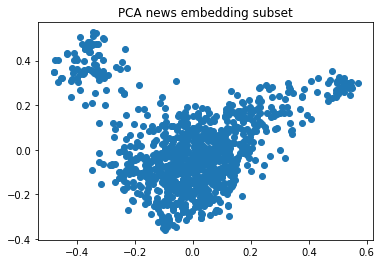

In [13]:
from sklearn.decomposition import PCA

PCA_news_embeddings_subset_no_dupl = PCA(n_components=2, svd_solver= 'full',random_state=42).fit_transform(news_embeddings_no_dupl[:1000])

plt.title("PCA news embedding subset")
plt.scatter(PCA_news_embeddings_subset_no_dupl[:,0], PCA_news_embeddings_subset_no_dupl[:,1])
plt.show()

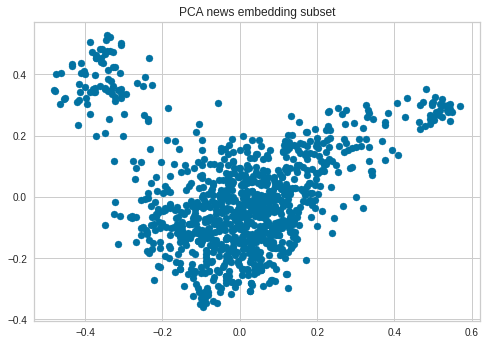

In [59]:
from sklearn.decomposition import PCA

PCA_news_embeddings_subset_no_dupl = PCA(n_components=2, svd_solver= 'arpack',random_state=42).fit_transform(news_embeddings_no_dupl[:1000])

plt.title("PCA news embedding subset")
plt.scatter(PCA_news_embeddings_subset_no_dupl[:,0], PCA_news_embeddings_subset_no_dupl[:,1])
plt.show()

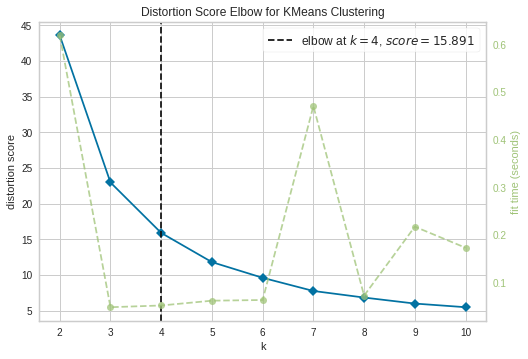

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=42)

elb_visualizer = KElbowVisualizer(model, k=(2,11))
elb_visualizer.fit(PCA_news_embeddings_subset_no_dupl)    
elb_visualizer.show()  

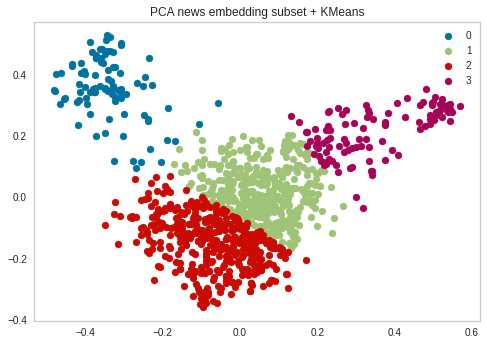

In [21]:
kmeans_clusts_news_embeddings_subset_no_dupl = KMeans(
    n_clusters=4, 
    random_state=42, 
    init="k-means++"
).fit_predict(PCA_news_embeddings_subset_no_dupl)

plt.title("PCA news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset_no_dupl):
    plt.scatter(
        PCA_news_embeddings_subset_no_dupl[kmeans_clusts_news_embeddings_subset_no_dupl == clust, 0],
        PCA_news_embeddings_subset_no_dupl[kmeans_clusts_news_embeddings_subset_no_dupl == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.grid(False)
plt.show()

**У кластері 0 чітко видно, що новини стосуються журналіста**

In [24]:
df_no_dupl.iloc[:1000][kmeans_clusts_news_embeddings_subset_no_dupl == 0].Text_processed.to_list()[:15]

['В Ирпене расстреляли корреспондента The New York Times. Об этом сообщает глава управления Нацполиции Киевской области Андрей Небытов. Оккупанты цинично убивают даже журналистов международных СМИ, которые пытаются показать правду о бесчинствах российских войск в Украине. Еще один журналист ранен. Сейчас потерпевшего пытаются вывести из зоны боевых действий. Конечно, профессия журналиста предполагает риск, впрочем, гражданин США Брент Рено поплатился жизнью за попытку осветить подлость, жестокость и безжалостность агрессора , - уточняет Небытов. Брент Рено - писатель, фотограф и режиссер-документалист, обладатель премии Пибоди, помимо работы, читал лекции студентам факультетов журналистики. VESTI',
 'В больницу Охматдет привезли раненого американского журналиста, где ему оказывают медицинскую помощь . Он еще не знает, что его коллега погиб. Украина Online',
 'Sky TG24: автобус с гражданами Украины перевернулся в Италии, погибла женщина. Автобус с украинцами перевернулся в Италии, погиб

**У кластері 3 новини в основному про переговори та можливі зустрічі**

In [26]:
df_no_dupl.iloc[:1000][kmeans_clusts_news_embeddings_subset_no_dupl == 3].Text_processed.to_list()[:15]

['Представитель Кремля Дмитрий Песков высказался о возможности встречи президентов РФ и Украины Владимира Путина и Владимира Зеленского . Песков прокомментировал возможность встречи Путина и Зеленского: Никто не исключает . Представитель Кремля Дмитрий Песков высказался о возможности встречи президентов РФ и Украины Владимира Путина и Владимира Зеленского .',
 'Однако заявления Зеленского, Кулебы и ряда других украинских политиков говорят об обратном . В офисе Зеленского заявили о приближении компромисса с Россией . Москва и Киев приближаются к компромиссу на переговорах, заявил советник главы офиса президента Украины Михаил Подоляк.',
 'Киев и Москва заявляют о движении к компромиссу на фоне продолжения боевых действий. Советник президента Украины: Россия уже адекватнее смотрит на ситуацию . Киев и Москва заявляют о движении к компромиссу на фоне продолжения боевых действий.',
 'Президент России Владимир Путин в телефонном разговоре с турецким лидером накануне заявил, что не против вс

## DBSCAN

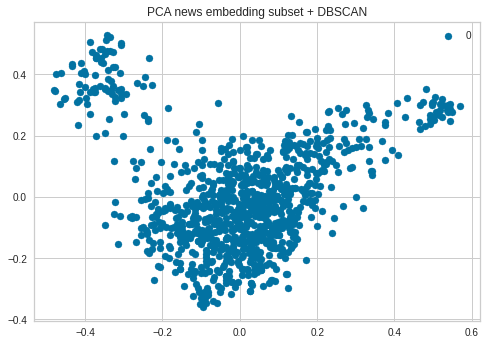

In [75]:
dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=3,
    min_samples=6,
     metric='euclidean'
).fit_predict(PCA_news_embeddings_subset_no_dupl)

plt.title("PCA news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        PCA_news_embeddings_subset_no_dupl[dbscan_clusts_news_embeddings_subset == clust, 0],
        PCA_news_embeddings_subset_no_dupl[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()



Оскільки значення eps завелике,  необхідно підрахувати відстані між кожною точкою та її сусідом 

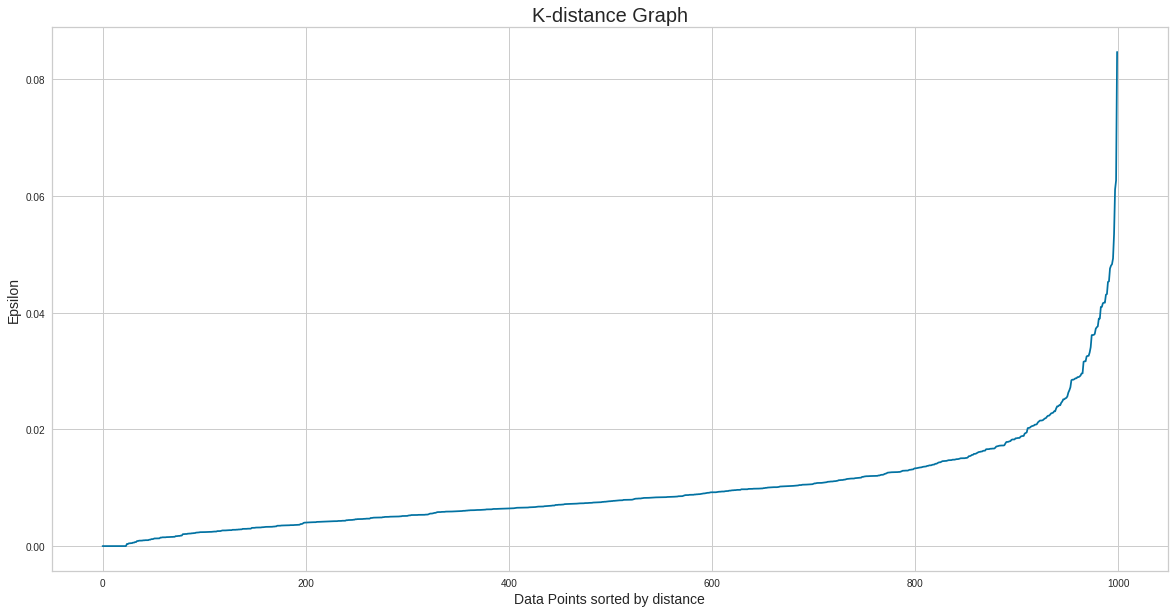

In [77]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(PCA_news_embeddings_subset_no_dupl)
distances, indices = nbrs.kneighbors(PCA_news_embeddings_subset_no_dupl)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(20,10))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

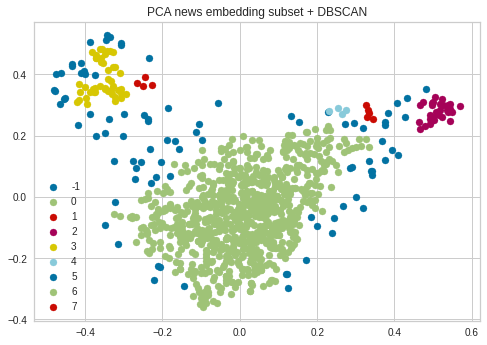

In [88]:
dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=0.03,
    min_samples=4,
     metric='euclidean'
).fit_predict(PCA_news_embeddings_subset_no_dupl)

plt.title("PCA news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        PCA_news_embeddings_subset_no_dupl[dbscan_clusts_news_embeddings_subset == clust, 0],
        PCA_news_embeddings_subset_no_dupl[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()



**У кластері 3 містяться новини про журналістів**

In [98]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 3].Text.to_list()[:10]


['Журналист New York Times и режиссёр-документалист Брент Рено погиб на Украине. \n\nОб этом на странице в Facebook сообщил начальник полиции Киевской области Андрей Небитов. Он опубликовал фото документов журналиста и его тела.\n\n@infomoscow24',
 'На Украине погиб известный журналист New York Times и ранен один из его коллег. Об этом сообщил начальник полиции Киевской области, он же опубликовал фотографии тела и документов репортёра.\n\nБрент Рено — известный режиссёр-документалист, который вместе с братом освещал происходящее в горячих точках мира',
 'Сообщается, что на Украине погиб журналист New York Times Брент Рено. Об этом сообщает начальник Киевской полиции.  Рено прославился, освещая происходящее в горячих точках мира\n\n@truekpru',
 'Белый дом консультируется с Киевом по поводу сообщений о гибели американского журналиста на Украине — помощник Байдена Салливан\n\n@truekpru',
 'В Белом доме уточнили, что у США пока нет подтверждения сообщений о возможной гибели американского ж

**у кластері 1 новини про лікарів, хвороби**

In [102]:
df_no_dupl.iloc[:1000][dbscan_clusts_news_embeddings_subset == 1].Text.to_list()


['Интернеты все помнят.\n\nВ 2009 г. в Тернополе возник вирус неизвестного происхождения, вызвавший геморрагическую пневмонию: погибли 450 украинцев. В 2011 году на Украине была вспышка холеры - умерли 33 человека, в 2014 году холерой заразились уже 800 украинцев. В январе 2016 года в Харькове 20 военных умерли от похожего на грипп вируса, более 200 человек были госпитализированы. Двумя месяцами позже в стране было зафиксировано 364 смертельных случая.',
 'Украина Сейчас: новости, война, Россия\n03/13/2022 06:28:25 +00:00 @u_now\nПоследствия прилета ракет во Львовской области на Яворивский полигон\n\nПредварительно, погибших нет.\n\nУС &gt; Подписаться\n',
 '\xa0#спецоперация\xa0#украина\nЧитать -\xa0https://russian.rt.com/ussr/news/975263-lnr-mesta-massovogo-ubiistva-zhitelei\r\nСиловики ЛНР нашли места массового убийства жителей около Попаснянской железной дороги\r\nСилы ЛНР во время наступления на Попаснянском направлении нашли места массового убийства мирных жителей в районе железн

# **topic modelling for finding interesting topics**

In [120]:
nltk.download("stopwords")
ru_stopwords = stopwords.words("russian")
ru_stopwords_puncts = set(ru_stopwords) | set(string.punctuation)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [126]:
nltk.download('punkt')
docs = []
for d in tqdm(df_no_dupl.iloc[:1000]['Text_processed'].to_list()):
    docs.append(
        [el.lower() for el in tokenize.word_tokenize(d) if el.lower() not in ru_stopwords_puncts]
    )

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 1000/1000 [00:01<00:00, 585.40it/s]


In [128]:
vocab = corpora.Dictionary(docs)
# doc2bow means Doc transformed to Bag of Words
corpus = [vocab.doc2bow(text) for text in docs]
print(
    f"Text:\n{' '.join(docs[5])}\n\n"
    f"Text BOW:\n{corpus[5]}"
)

Text:
военная операция украине изменила отношение компаний россии пришлось сделать выбор потерять репутацию приостановить работу стране этих событий бренды несколько подумают прежде снова захотят развивать бизнес россии vc.ru/finance/374622

Text BOW:
[(86, 1), (135, 2), (176, 1), (177, 1), (178, 1), (179, 1), (180, 1), (181, 1), (182, 1), (183, 1), (184, 1), (185, 1), (186, 1), (187, 1), (188, 1), (189, 1), (190, 1), (191, 1), (192, 1), (193, 1), (194, 1), (195, 1), (196, 1), (197, 1), (198, 1), (199, 1)]


In [ ]:
num_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=vocab,
                                       num_topics=num_topics)


In [131]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"украине" + 0.008*"украины" + 0.007*"россии" + 0.006*"кадыров" + '
  '0.006*"сша" + 0.005*"рф" + 0.005*"жителей" + 0.005*"глава" + 0.004*"заявил" '
  '+ 0.004*"\'\'"'),
 (1,
  '0.014*"украине" + 0.009*"россии" + 0.009*"украины" + 0.008*"``" + '
  '0.007*"\'\'" + 0.005*"рф" + 0.004*"сша" + 0.003*"области" + '
  '0.003*"спецоперации" + 0.003*"минобороны"'),
 (2,
  '0.012*"украине" + 0.010*"украины" + 0.005*"рф" + 0.005*"``" + 0.004*"\'\'" '
  '+ 0.004*"спецоперации" + 0.004*"области" + 0.004*"против" + 0.004*"россии" '
  '+ 0.003*"тысяч"'),
 (3,
  '0.013*"украине" + 0.007*"``" + 0.007*"рф" + 0.007*"россии" + '
  '0.007*"украиной" + 0.007*"\'\'" + 0.007*"заявил" + 0.006*"украины" + '
  '0.006*"лнр" + 0.006*"переговорах"'),
 (4,
  '0.016*"украине" + 0.009*"украины" + 0.007*"россии" + 0.005*"спецоперации" + '
  '0.004*"рф" + 0.004*"видео" + 0.004*"российских" + 0.004*"военных" + '
  '0.003*"это" + 0.003*"военной"'),
 (5,
  '0.012*"украине" + 0.009*"украины" + 0.007*"россии" + 

## **BERTopic**

In [132]:
from bertopic import BERTopic
topic_model = BERTopic(embedding_model="DeepPavlov/rubert-base-cased", verbose=True)

In [134]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,260,-1_на_украине_что_из
1,0,53,0_соболезнования_спецоперации_украине_области
2,1,51,1_не_то_это_что
3,2,46,2_рено_times_new_york
4,3,46,3_иностранных_наемников_рф_минобороны
5,4,45,4_рено_журналиста_гибели_times
6,5,42,5_рф_объектов_иностранных_вс
7,6,39,6_будут_сша_нато_американские
8,7,34,7_акции_поддержку_на_автопробег
9,8,32,8_лнр_жителей_мирных_массового


In [135]:
topic_model.visualize_topics()


In [ ]:
topics, probs = topic_model.fit_transform(df_no_dupl['Text_processed'][:10000].to_list())

In [210]:
df = df_no_dupl
df = df.iloc[:10000]

df['topics'] = topics

In [213]:
df['Date'] = pd.to_datetime(df['Date'])

In [211]:
df.groupby("Date")["topics"].apply(list)

Date
2022-03-11                                                 [-1]
2022-03-12    [11, 41, -1, 26, 127, 43, -1, 146, -1, -1, -1,...
2022-03-13    [56, -1, 19, 27, 19, -1, 34, 60, 83, -1, 42, -...
2022-03-14    [-1, -1, -1, 18, -1, 8, 30, 56, -1, 36, -1, 17...
2022-03-15    [-1, 49, 164, 134, 24, 160, -1, 106, 144, 12, ...
Name: topics, dtype: object

In [209]:
df[df['topics']==4].groupby(df["Date"])["topics"].count()


Date
2022-03-13    19
2022-03-14    67
2022-03-15    38
Name: topics, dtype: int64

### **Загалом новини про журналіста писались протягом 3 днів в березні**

In [214]:
# total amount per month 
df[df['topics']==4].groupby(df["Date"].dt.month)["Text"].count()

Date
3    124
Name: Text, dtype: int64